# NLP Project: Making a prediction of the Programming Language base on README.md
"We don't know, what we don't know"  

By: Cody Watson and Eric Escalante  
May 13, 2019  

In this Jupyter Notebook, we will be scraping data from GitHub repository README files. The goal is to build a model that can predict which programming language a repository is using, given the text of the README file.

## Imports
**Import the necessary packages and their use cases for this project:**
> **pandas:** data frames and data manipulation  
> **numpy:** summary statistics  
> **matplotlib:** used for visualizations  
> **seasborn:** fancy visualizations  
> **datetime:** turn the dates into datetime objects / get day of week  
> **warning:** used to ignore python warnings  
> **requests:** to obtain the HTML from the page  
> **unicodedata:** character encoding  
> **BeautifulSoup:** to parse the HTML and obtain the text/data that we want  
> **nltk:** Natual Language Toolkit that allows us to work with human language data  
> **WordCloud:** creates an image composed of words used in a particular text or subject, in which the size of each word indicates its frequency or importance

In [293]:
import unicodedata
import re
import json

import spacy
from spacy.lang.en import English
import nltk
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.corpus import stopwords

import pandas as pd
import numpy as np
import NLP_acquire
from typing import List, Dict
from pprint import pprint

## Table of contents
1. [Project Planning](#project-planning)
1. [Preparation](#preparation)
1. [Exploration](#exploration)
1. [Modeling](#modeling)
1. [Summary](#summary)

## Project Planning <a name="project-planning"></a>

### Goals  
> Goals for the Project are:  
1. Accurately predict the programming languages based on mutliple programming languages from Github README files
2. Create different WordCloud models showing the most commonly used words with each programming languages
3. Built muliple Classification machine learning models to accurately predict which language the repository is written in
4. Be sure that we are documenting our thoughts throughout the process

### Deliverables
>- A well-documented jupyter notebook that contains your analysis  
>- One or two google slides suitable for a general audience that summarize your findings. Include a well-labelled visualization in your slides.

### Hypotheses
> "C++ programmers are more elitist"

### Thoughts & Questions
> **Thoughts:**  
- Figure out how to apply multiple Classification methods to predict programming language using the repo's readme.md
- Figure out how to apply multiple sentiment analysis methods to the data
- Compare and Contrast different Corpus using TF-IDF
- We want to learn how to set up the Word2Vec for word embedding
- Apply a 'github' image mask to a WordCloud (within the negative/positive space; label each space with different colors)

> **Questions:**  
- What am I? Who are we?
- Does the sentiment in a given languange vier more towards positive or negative?
- How many graphs can we make this weekend??

## Prepare the Environment <a name="preparation"></a>

**Bring in the data from the prepare file**

In [294]:
df = pd.read_json('data.json')

**Going to see what the top portion looks like**

In [295]:
df.head()

,language,readme_contents,repo
0,JavaScript,"<p align=""center"">\n <a href=""https://getboot...",twbs/bootstrap
1,JavaScript,# [React](https://reactjs.org/) &middot; [![Gi...,facebook/react
2,None,This page is available as an easy-to-read webs...,EbookFoundation/free-programming-books
3,None,"<div align=""center"">\n\t<img width=""500"" heigh...",sindresorhus/awesome
4,None,![Web Developer Roadmap - 2019](https://i.imgu...,kamranahmedse/developer-roadmap


**How many Languages does our CSV have?**

In [296]:
df.language.value_counts()

JavaScript          43
Python              22
Go                   7
Java                 6
C++                  6
CSS                  3
Jupyter Notebook     2
Swift                2
HTML                 2
Ruby                 2
Dart                 1
Rust                 1
C#                   1
C                    1
Assembly             1
TypeScript           1
PHP                  1
Name: language, dtype: int64

In [297]:
### pretrained tokenizer (use code if not downloaded)
#nltk.download('punkt')
### removes words that don't really matter (use code if not downloaded)
#nltk.download('stopwords')

**Funtions to clean our readme files**

In [298]:
def basic_clean(text):
    '''
    Function that takes a string and normalized the text using unicodedata
    '''
    text = unicodedata.normalize('NFKD', text.lower())\
        .encode('ascii', 'ignore')\
        .decode('utf-8', 'ignore')
    return re.sub(r"[^a-z0-9'\s]", ' ', text)

def stem(text):
    ps = nltk.porter.PorterStemmer()
    stems = [ps.stem(word) for word in text.split()]
    return ' '.join(stems)

def lemmatize(text):
    '''
    Function that lemmatizes the string
    '''
    nlp = spacy.load('en', parse=True, tag=True, entity=True)
    doc = nlp(text) # process the text with spacy
    lemmas = [word.lemma_ for word in doc]
    text_lemmatized = ' '.join(lemmas)
    return re.sub(r"\s*(-PRON-|\'s|\')", '', text_lemmatized)

def remove_stopwords(text):
    '''
    Function to remove stopwords from the string
    '''
    tokenizer = ToktokTokenizer()
    stopword_list = stopwords.words('english')
    stopword_list.remove('no')
    stopword_list.remove('not')
    tokens = tokenizer.tokenize(text)
    filtered_tokens = [t for t in tokens if t not in stopword_list]
    return filtered_tokens

def clean_readme(string):
    '''
    Function that pipes the funtions together
    '''
    return remove_stopwords(stem(basic_clean(string)))

**Apply our funcitons**

In [299]:
df['readme_clean'] = df.readme_contents.apply(clean_readme)

**Thoughts:**
>- We no longer need the original readme contents, going to dump them
>- We need to now group by the language
>- We are going to start using WordCloud to visually see the frequencies of each word

In [300]:
df.drop(columns=['readme_contents', 'repo'], inplace=True)

In [301]:
df.to_csv('cleaned_dataframe.csv', index=False)

### ---Prepare Complete---

**Clean CSV to work with**

In [302]:
df = pd.read_csv('cleaned_dataframe.csv')

In [303]:
df.head()

,language,readme_clean
0,JavaScript,"['p', 'align', 'center', 'href', 'http', 'getb..."
1,JavaScript,"['react', 'http', 'reactj', 'org', 'middot', '..."
2,NaN,"['thi', 'page', 'avail', 'easi', 'read', 'webs..."
3,NaN,"['div', 'align', 'center', 'img', 'width', '50..."
4,NaN,"['web', 'develop', 'roadmap', '2019', 'http', ..."


## Exploration  <a name="exploration"></a>

**Thoughts:**
>- Look at Top\Bottom 10 words in each readme grouped by programming language
>- Sentiment Analysis on each languange
>- Figure out how to apply latent Dirichlet allocation
>- Learn how to set up Word2Vec

In [304]:
def get_frequency(df, language):
    '''
    Function that creates a dataframe with words in the repo and their counts
    '''
    language_dict = {}
    temp_df = df[df['language'] == str(language)]
  
    for i, row in temp_df.iterrows():
        row_text = str(row['readme_clean'])
        row_text_words = row_text.split(' ')
    
    for word in row_text_words:
        if word in language_dict:
            language_dict[word] += 1
        else:
            language_dict[word] = 1
        
    return pd.DataFrame.from_records(language_dict, index=[0]).T

**Grab any language and find the frequency**

In [305]:
js_frequency = get_frequency(df, 'JavaScript')
python_frequency = get_frequency(df, 'Python')
go_frequency = get_frequency(df, 'Go')
java_frequency = get_frequency(df, 'Java')
cplus_frequency = get_frequency(df, 'C++')
css_frequency = get_frequency(df, 'CSS')

**What are the 20 most common words on the Java Readme's?**

**Graphs**
>- Stacked Bargraph (done)
- WordCloud (done)
- Add in bigrams and trigrams; could add more *grams

In [306]:
df.language.value_counts()

JavaScript          43
Python              22
Go                   7
Java                 6
C++                  6
CSS                  3
Jupyter Notebook     2
Swift                2
HTML                 2
Ruby                 2
Dart                 1
Rust                 1
C#                   1
C                    1
Assembly             1
TypeScript           1
PHP                  1
Name: language, dtype: int64

In [307]:
top_20_js_words = js_frequency.sort_values([0], ascending=False).head(20)
top_20_js_words.reset_index(inplace=True)
top_20_js_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_py_words = python_frequency.sort_values([0], ascending=False).head(20)
top_20_py_words.reset_index(inplace=True)
top_20_py_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_go_words = go_frequency.sort_values([0], ascending=False).head(20)
top_20_go_words.reset_index(inplace=True)
top_20_go_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_java_words = java_frequency.sort_values([0], ascending=False).head(20)
top_20_java_words.reset_index(inplace=True)
top_20_java_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_cplus_words = cplus_frequency.sort_values([0], ascending=False).head(20)
top_20_cplus_words.reset_index(inplace=True)
top_20_cplus_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

top_20_css_words = css_frequency.sort_values([0], ascending=False).head(20)
top_20_css_words.reset_index(inplace=True)
top_20_css_words.rename(columns={'index': 'words', 0: 'freq'}, inplace=True)

### JavaScript Word Frequency Visuals

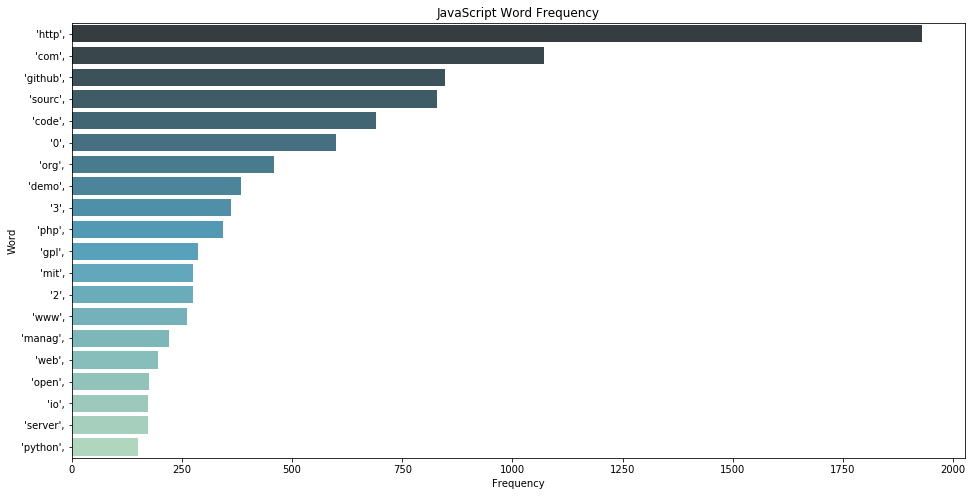

In [393]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(16,8))
sns.barplot(top_20_js_words.freq, top_20_js_words.words, palette='GnBu_d')
plt.title('JavaScript Word Frequency')

plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

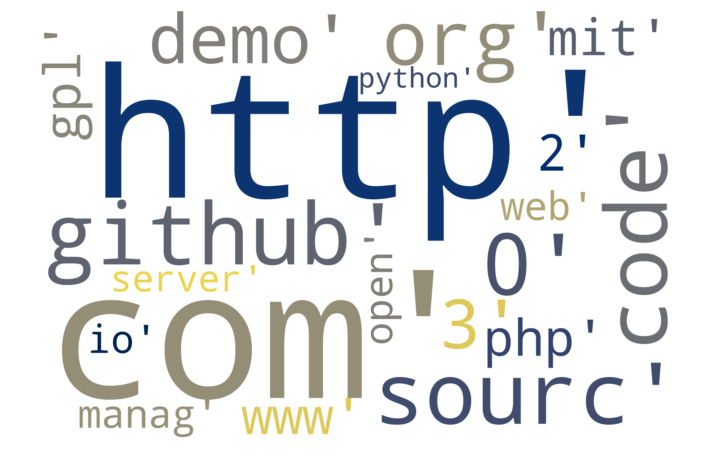

In [370]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_js_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    colormap=plt.cm.cividis,
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Thoughts:**
>_todo_

### Python Word Frequency Visuals

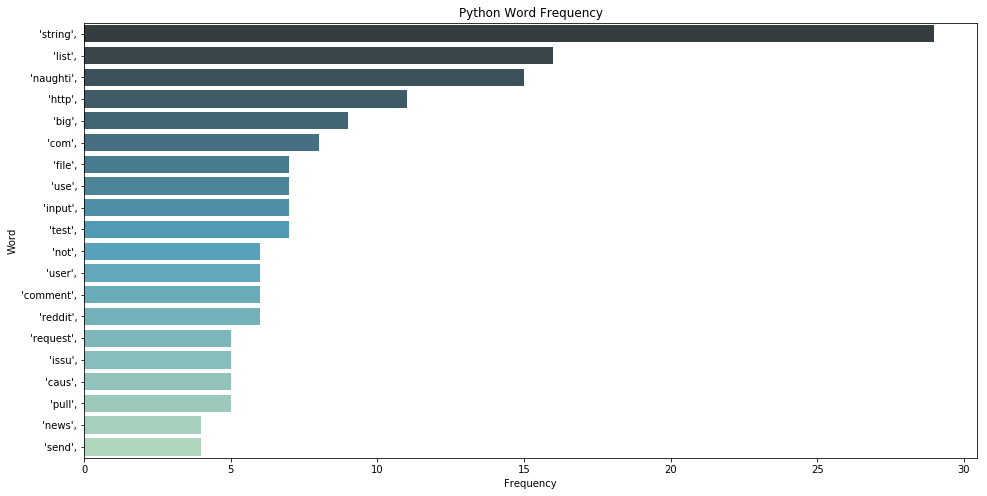

In [391]:
plt.figure(figsize=(16,8))
sns.barplot(top_20_py_words.freq, top_20_py_words.words, palette='GnBu_d')

plt.title('Python Word Frequency')
plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

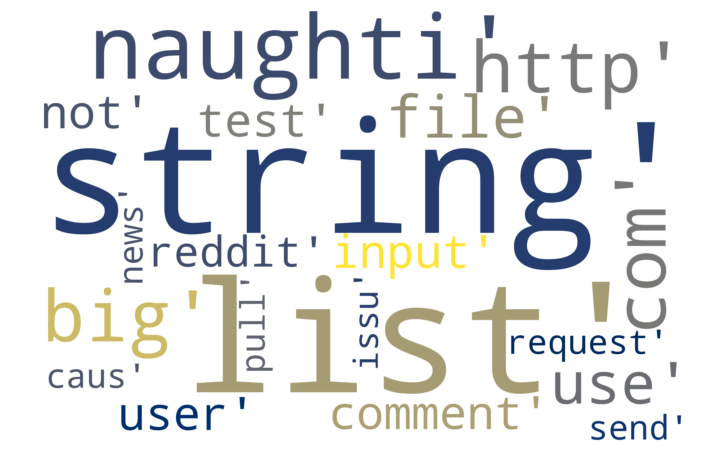

In [375]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_py_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    colormap=plt.cm.cividis,
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

**Thoughts:**
>_todo_

### Go programming language Word Frequency Visuals

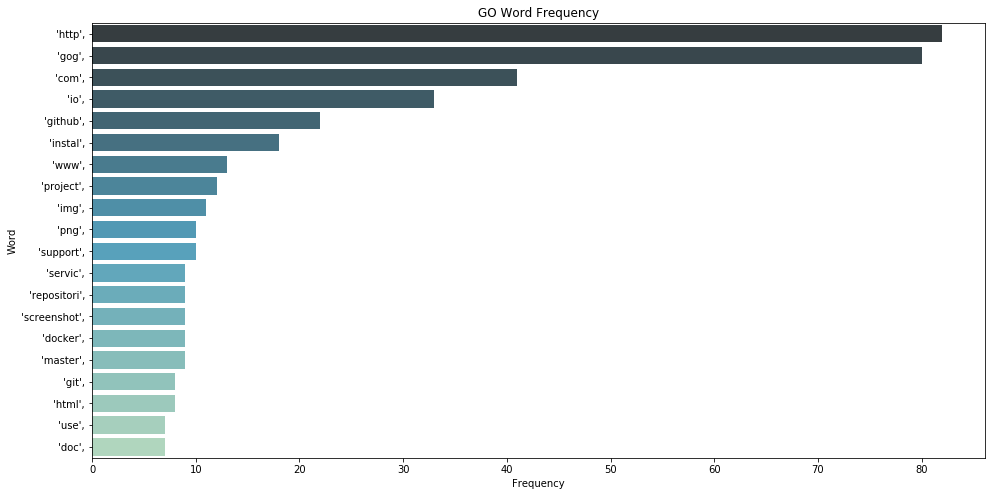

In [394]:
plt.figure(figsize=(16,8))
sns.barplot(top_20_go_words.freq, top_20_go_words.words, palette='GnBu_d')

plt.title('GO Word Frequency')
plt.ylabel('Word')
plt.xlabel('Frequency')
plt.show()

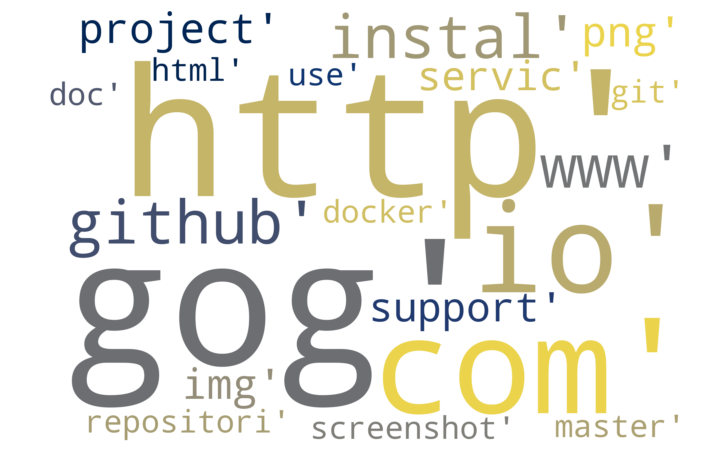

In [372]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

text = top_20_go_words.words.values
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    colormap=plt.cm.cividis,
    stopwords = STOPWORDS).generate(str(text))

fig = plt.figure(
    figsize = (16, 8))

plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.show()

**Thoughts:**
>- What do the bigrams look like with each language
>- Is there a difference with each language?

### Questions to Answer
- What are the most common words in READMEs?  
- What does the distribution of IDFs look like for the most common words?  
- Does the length of the README vary by language?  
- Do different languages use a different number of unique words?

**Building a chart that shows us which words are unique and common throughout the top six languages**

In [314]:
import networkx as nx

/usr/local/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


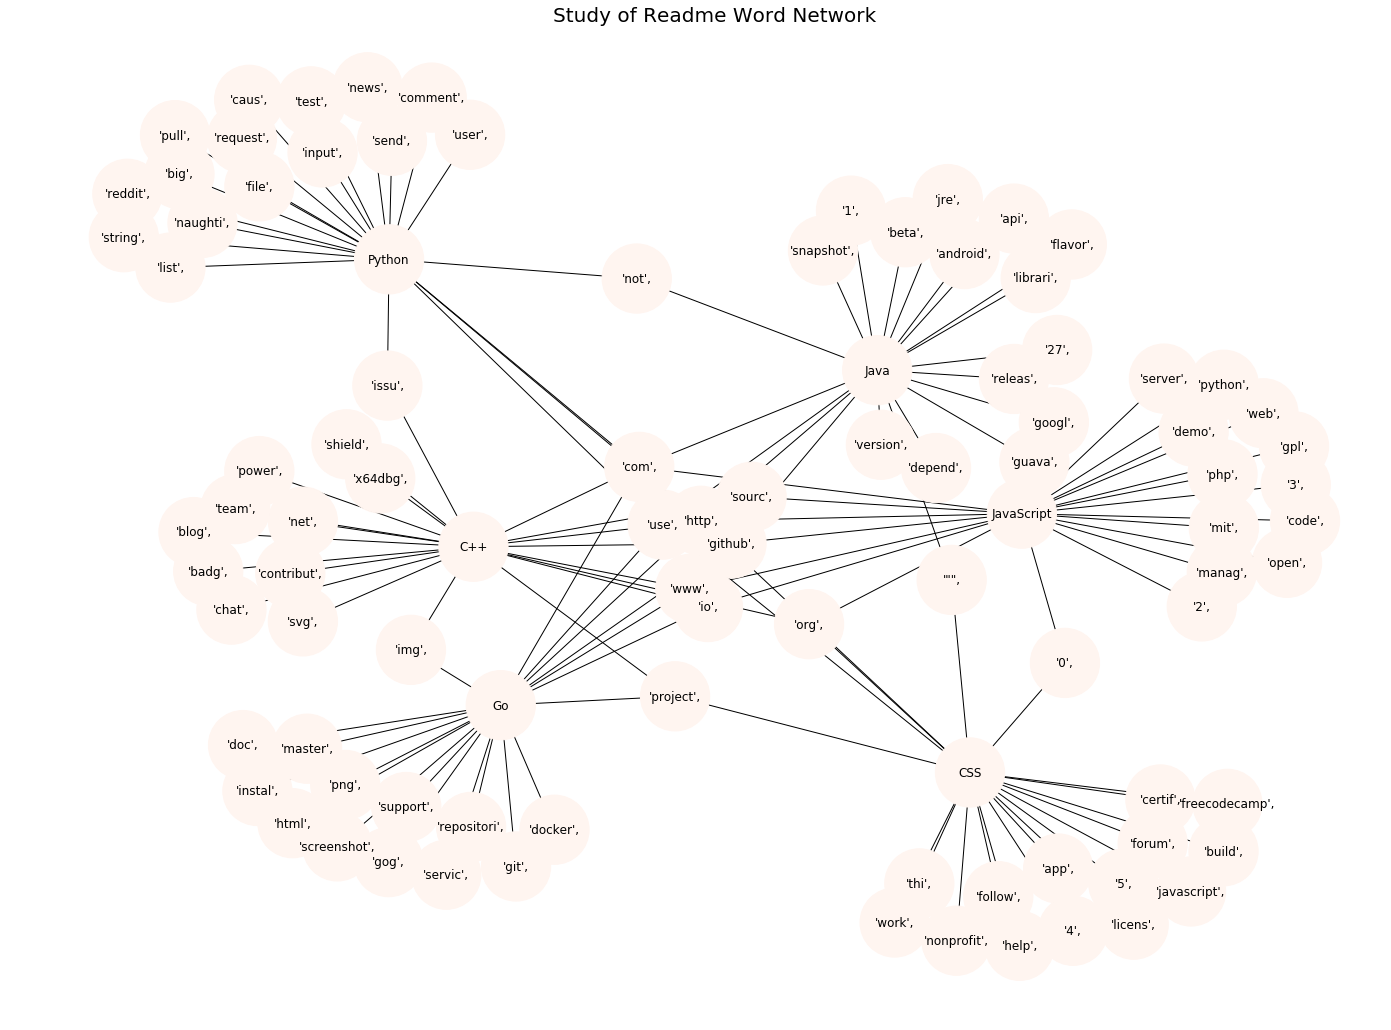

In [343]:
G = nx.Graph()
plt.figure(3,figsize=(24,18)) 

for word in top_20_py_words.words:
    G.add_edge('Python', word)

for word in top_20_go_words.words:
    G.add_edge('Go', word)

for word in top_20_js_words.words:
    G.add_edge('JavaScript', word)
    
for word in top_20_java_words.words:
    G.add_edge('Java', word)

for word in top_20_cplus_words.words:
    G.add_edge('C++', word)

for word in top_20_css_words.words:
    G.add_edge('CSS', word)


values = [1.0 for node in G.nodes()]
edge_colours = ['black' for edge in G.edges()]
black_edges = [edge for edge in G.edges()]

pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, cmap=plt.get_cmap('Reds'), node_color = values, node_size=4800)
nx.draw_networkx_edges(G, pos, edgelist=black_edges, arrows=True)
nx.draw_networkx_labels(G,pos,font_size=12,font_family='sans-serif')

plt.title('Study of Readme Word Network', fontsize=20)
plt.axis('off')
plt.show()

**Explanation:**
> We used the top 20 words in each language to build a word network. Each programming language contains certain unique words and words that are common in multiple languages. The Network shows the programming language as a unique node and the edges show the word relationship between the languages. From here we can answer the questions above.

### ---Explore Complete---

## Modeling <a name="modeling"></a>

**Bring in multiple classification models**
> TF-IDF  
> Logistic Regression  
> Decision Tree (Best Train Model)  
> Random Forest  
> KNN

### Feature Extraction: TF-IDF

In [316]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [317]:
vectorizer = TfidfVectorizer()

In [318]:
features = vectorizer.fit_transform(df.readme_clean.values)  
features = features.todense()

features.shape

(108, 19464)

**List of unique words**

In [319]:
feature_names = vectorizer.get_feature_names()
print(feature_names[:10])

['00', '000', '0000', '00000000', '00042', '000z', '001', '0010', '0033ff', '004']


**Create a Dataframe with the new features**

In [320]:
tf_idf = pd.DataFrame(data=features,
                  columns=feature_names)
tf_idf.head()

,00,000,0000,00000000,00042,000z,001,0010,0033ff,004,...,zxing,zy,zy3qpxmz,zydi,zyecca,zynga,zyszi,zyszys98,zyuwsjuxxuq,zzfhjytdceu
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.027863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.002974,0.0,0.0,0.0,0.0,0.002429,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


### Train-Test Split
>- We need to make sure our dataframe does not include NaN values
>- We need to make sure our languages contain more than one readme for the classification methods to work

**Drop all null values**

In [321]:
df.replace('-', np.nan, inplace = True)
df = df.dropna()

**Clean up our dataframe**
>- Take our all languages with only 1 README.md
>- We chould build a loop here, but we just want to push through to modeling

In [322]:
df = df[df.language != 'Rust']
df = df[df.language != 'C']
df = df[df.language != 'Assembly']
df = df[df.language != 'Dart']
df = df[df.language != 'TypeScript']
df = df[df.language != 'C#']
df = df[df.language != 'PHP']

### Import multiple sklearn algorithms so that we can build modles

In [323]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

**Split our data into independent and dependent variables**

In [324]:
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df.readme_clean)
y = df.language

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=.2)

train = pd.DataFrame(dict(actual=y_train))
test = pd.DataFrame(dict(actual=y_test))

### Logistic Regression

In [325]:
lm = LogisticRegression(solver='saga',multi_class='multinomial', max_iter=120, verbose=True).fit(X_train, y_train)

train['predicted'] = lm.predict(X_train)
test['predicted'] = lm.predict(X_test)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


max_iter reached after 0 seconds


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/sag.py:334: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.7s finished


In [326]:
print('Accuracy: {:.2%}'.format(accuracy_score(train.actual, train.predicted)))
print('---')
print('Confusion Matrix')
print(pd.crosstab(train.predicted, train.actual))
print('---')
print(classification_report(train.actual, train.predicted))

Accuracy: 73.68%
---
Confusion Matrix
actual      C++  CSS  Go  HTML  Java  JavaScript  Jupyter Notebook  Python  \
predicted                                                                    
C++           2    0   0     0     0           0                 0       0   
Java          0    0   0     0     2           0                 0       0   
JavaScript    3    2   5     2     3          34                 2       0   
Python        0    0   0     0     0           0                 0      18   

actual      Ruby  Swift  
predicted                
C++            0      0  
Java           0      0  
JavaScript     2      1  
Python         0      0  
---
                  precision    recall  f1-score   support

             C++       1.00      0.40      0.57         5
             CSS       0.00      0.00      0.00         2
              Go       0.00      0.00      0.00         5
            HTML       0.00      0.00      0.00         2
            Java       1.00      0.40     

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Decision Tree Classification Method

In [349]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=123,
            splitter='best')

In [350]:
y_pred = clf.predict(X_train)
y_pred_proba = clf.predict_proba(X_train)

In [351]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.89


In [352]:
confusion_matrix(y_train, y_pred)

array([[ 5,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  2,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  5,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  2,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 34,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  3,  0,  0, 15,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  0,  0,  0]])

In [353]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.68


### Random Forest Classification Method

In [332]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=100,
                            max_depth=3, 
                            random_state=123)

rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=123, verbose=0, warm_start=False)

In [333]:
y_pred = rf.predict(X_train)
y_pred_proba = rf.predict_proba(X_train)

In [334]:
print('Accuracy of random forest classifier on training set: {:.2f}'
     .format(rf.score(X_train, y_train)))

Accuracy of random forest classifier on training set: 0.63


In [335]:
print(confusion_matrix(y_train, y_pred))

[[ 0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  4  0  1  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0 34  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  4  0 14  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0]]


### KNN Classifier

In [336]:
knn = KNeighborsClassifier(n_neighbors=5, weights='uniform', algorithm='brute')
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')

In [337]:
y_pred = knn.predict(X_train)
y_pred_proba = knn.predict_proba(X_train)

In [338]:
print('Accuracy of KNN classifier on training set: {:.2f}'
     .format(knn.score(X_train, y_train)))

Accuracy of KNN classifier on training set: 0.64


In [339]:
print(confusion_matrix(y_train, y_pred))

[[ 0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  5  0  0  0  0]
 [ 0  0  0  2  0  0  0  0  0  0]
 [ 0  0  0  1  2  2  0  0  0  0]
 [ 0  0  0  1  0 33  0  0  0  0]
 [ 0  0  0  0  0  0  2  0  0  0]
 [ 0  0  0  0  0  7  1 10  0  0]
 [ 0  0  0  0  0  2  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0]]


([<matplotlib.axis.XTick at 0x1a2b7f8fd0>,
 <a list of 5 Text xticklabel objects>)

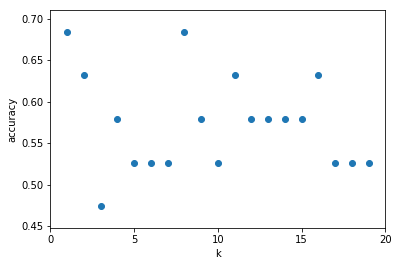

In [340]:
k_range = range(1, 20)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    scores.append(knn.score(X_test, y_test))
plt.figure()
plt.xlabel('k')
plt.ylabel('accuracy')
plt.scatter(k_range, scores)
plt.xticks([0,5,10,15,20])

### ---Explore Complete---

### Summarize Conclusions <a name="summary"></a>
>- Decistion Tree Classification Method performed the best with multinominal data.  
>- Hypothesis Result: C++ programming README's unique words include: 'power', 'shield', 'team', and 'badge'. C++ programmers may have a minor superior complex, but the unique vocabulary does make them an elitist.

### Find different ways to improve model:
>- Use Googles' Word2vec dictionary to assign the words in each read me a key that will hopefully improve each model
>- Use and define each programming language's Sentiment Analysis
>- Print the polarity for sentiment analysis in a dataframe